In [21]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from scipy.stats import norm
from IPython import display
from ipywidgets import IntProgress

# add here the libraries you need

In [2]:
# Utilities

def is_in_0_1(p):
    """Check if p is a vector whose elements are in [0,1]"""
    for prob in p:
        if 0 > prob or 1 < prob:
            return False
    return True

def is_prob_vector(p):
    """Check if p is a vector whose elements are in [0,1] and sum up to one"""
    threshold = 1e-10
    acc = 0
    for prob in p:
        acc += prob
    return abs(acc - 1) < threshold and is_in_0_1(p)

# Just a "decoration"
class ProgressBar:
    """Class that models a progress bar for this notebook."""
    def __init__(self, TOT, dele = False, symbol = "·"):
        assert TOT > 0
        
        out = "0% ["
        for i in range(100): out += " "
        out += "]"
        self.dh = display.display(out,display_id=True)
        self.i = 0
        self.TOT = TOT
        self.dele = dele
        self.symbol = symbol
        
    def increment(self):
        assert self.i <= self.TOT 
        percentile = int(self.i/self.TOT * 100)
        out = str(percentile) + "% ["
        for p in range(percentile): out += self.symbol        
        for p in range(percentile,100): out += ' '
        out += "]"
        
        self.dh.update(out)
        self.i += 1
        
        if self.dele == True and self.i == self.TOT:
            print ("\033[A                             \033[A")

# Discrete Time Markov Chains - Part 2
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC simulation before attempting to solve it!
In order to complete this notebook, you need the models implemented in Part 1 notebook on DTMC.

### 1. Simulation of DTMC
Write a method that simulates a DTMC for `n` steps, where `n` is a parameter of the method, and returns the whole trajectory as output.

In [3]:
def sample_discrete(N,p):
    """Computes N samples from discrete probability vector p"""
    n = len(p)
    S = np.cumsum(p)
    U = np.random.uniform(low=0.0, high=1.0, size=N)
    sampled_indexes = np.empty(N)
    for j in range(N):
        for i in range(n):
            if S[i] > U[j]:
                sampled_indexes[j] = i
                break
    return sampled_indexes.astype(int)

def simulate_dtmc(transition_model, initial_prob_vector, n):
    """Given a stocastic matrix, an initial probability vector and the number of steps, simulates a trajectory of the DTMC"""
    assert n > -1, "Negative amount of steps."
    current_state = sample_discrete(1,initial_prob_vector)[0]
    trajectory = [current_state]
    if n == 0:
        return trajectory
    for i in range(n):
        current_state = sample_discrete(1,transition_model[current_state,:])[0]
        trajectory.append(current_state)
    return trajectory

In [4]:
# Model of a birth-death chain created in the previous exercises:
def check_vectors(N,p,q):
    """Function that checks if the vectors for a general birth-death chain of maximum population N are valid"""
    if len(p) != N or len(q) != N: # vectors must be of size N
        return False
    for i in range(N):
        if p[i] + q[i] > 1: # For every state, the sum of the probabilities should not exceed 1
            return False
    return True

def build_transition_birth_death(N, p, q):
    """Function that builds a transition matrix for a general birth-death chain of maximum population N, 
    given the vector of probabilities of birth and death"""
    assert check_vectors(N,p,q), "Wrong vectors."
    assert N > 0, "Negative max population"
    
    transition_birth_death = np.zeros((N,N))
    
    transition_birth_death[0,0] = 1 - p[0]
    transition_birth_death[0,1] = p[0]
    
    for i in range(1,N-1):
        transition_birth_death[i,i-1] = q[i-1]
        transition_birth_death[i,i+1] = p[i]
        transition_birth_death[i,i] = 1 - p[i] - q[i-1]
        
    transition_birth_death[N-1,N-2] = q[N-2]
    transition_birth_death[N-1,N-1] = 1 - q[N-2]
    
    return transition_birth_death

N = 5
p = np.array([0.2,0.3,0.5,0.6,0.4])
q = np.array([0.6,0.5,0.3,0.2,0.5])

transition_birth_death = build_transition_birth_death(N,p,q)
initial_prob_vector = np.array([0.,0.,1.,0.,0.])

In [5]:
trajectory = simulate_dtmc(transition_birth_death, initial_prob_vector, 10)
print("Simulation of 10 steps:", trajectory)

Simulation of 10 steps: [2, 3, 4, 4, 3, 2, 1, 0, 0, 1, 2]


### 2. Statistical analysis
Write methods for:
- 2.1. computing the average of a function `f` of the state space, at time step `n`.
- 2.2. computing the probability of reaching a target region `A` of the state space by time step `n`.

Both methods should use simulation, and return an estimate and a confidence interval at a specified confidence level `alpha` (0.95% by default).

In [6]:
def f(trajectory):
    """Returns the number of times that the state number 3 occurred in the trajectory."""
    acc = 0
    for state in trajectory:
        acc += 1 if state == 3 else 0
    return acc

In [7]:
def confidence_interval(samples, alpha=0.95):
    mean = np.mean(samples)
    std_dev = np.std(samples, ddof=1)
    perc = (1+alpha)/2
    q = norm.ppf(perc)
    epsilon = q * std_dev / np.sqrt(len(samples))
    rhs = round(mean + epsilon, 5)
    lhs = round(mean - epsilon, 5)
    return (lhs,rhs)

In [29]:
%%time
def f_average(f, transition_model, initial_prob_vector, n, alpha = 0.95):
    """Computes the average of f by simulation of DTMC of n steps. Arguments: function, stpcastic matrix, initial
    probability vector, number of steps and the confidence level. Outputs: the average and the confidence interval."""
    N_SIM = 10000 # number of simulations
    samples = []
    p = IntProgress(min=0,max=N_SIM)
    display.display(p)
    for i in range(N_SIM):
        trajectory = simulate_dtmc(transition_model, initial_prob_vector, n)
        y = f(trajectory)
        samples.append(y)
        p.value += 1
    p.bar_style = "success"
    return (np.mean(samples),confidence_interval(samples, alpha))

result = f_average(f,transition_birth_death,initial_prob_vector,10)
print("Average:", result[0], ". 95% confidence interval: (", result[1][0], ",", result[1][1], ").")

IntProgress(value=0, max=10000)

Average: 1.5801 . 95% confidence interval: ( 1.55129 , 1.60891 )
Wall time: 23.1 s


In [45]:
def hit_target(trajectory, target):
    """Return 1 if the trajectory hit the target region, otherwise 0."""
    for state in trajectory:
        if state in target:
            return 1
    return 0

def target_in_n(transition_model, initial_prob_vector, target, n, alpha=0.95):
    """Computes the probability, using simulation, of reaching a target region by time step n."""
    N_SIM = 10000
    samples = []
    p = IntProgress(min=0,max=N_SIM)
    display.display(p)
    for i in range(N_SIM):
        trajectory = simulate_dtmc(transition_model, initial_prob_vector, n)
        samples.append(hit_target(trajectory, target))
        p.value += 1
    p.bar_style = "success"
    return (np.mean(samples),confidence_interval(samples, alpha))

result = target_in_n(transition_birth_death, initial_prob_vector, [0,1], 20)
print("Average:", result[0], ". 95% confidence interval: (", result[1][0], ",", result[1][1], ").")

IntProgress(value=0, max=10000)

Average: 0.753 . 95% confidence interval: ( 0.74455 , 0.76145 ).


### 3. Branching chain
Consider a population, in which each individual at each
generation independently gives birth to $k$ individuals with
probability $p_k$. These will be the members of the next
generation. Assume $k\in\{-1, 0,1,2\}$. The population is initial compused of two individuals Adam and Eve.

#### Premises
Since the transition matrix is complex to calculate, especially for a large number of individuals, the simulation of the DTMC will directly computed. This brings two advantages:
- There is no need to compute a large stocastic matrix, since the number of individuals (and so the states)
- There is no need to define a maximum population, so the individuals can grow free.

In [35]:
%%time
def simulate_branching_chain(initial_pop, k_prob, gen_max):
    """Simulate a population modelled by a branching chain.
    Input: the initial population, a tuple that models the probability of an individual of generating k offsprings 
    (first entry is the probability to die, second to generate 0 offspirng and so on) and 
    how many generations it is wanted to simulate. 
    Output: the evolving of the number of individuals through the generations."""
    
    assert is_prob_vector(k_prob)
    assert initial_pop > 0
    
    pop = [initial_pop]
    
    for gen in range(gen_max): # simulation for gen_max generations
        current_pop = int(pop[-1]) # take the current population
        offsprings = 0
        for individual in range(current_pop): # for every individual of the population
            offsprings += int(sample_discrete(1,k_prob)) - 1 # sum the number of offsprings of the individual to 
            # the total offsprings of the current population. -1 is due to the indexing: state 0 means -1 individuals born,
            # state 1 is 0 individuals born and so on.
        pop.append(offsprings + current_pop) # the new generation is composed of the previous population + offspings 
        # (offsprings can be negative, leading to extintion)
        
        if int(pop[-1]) == 0:
            pop.append("Population extinted :(")
            break
    
    return pop

simulate_branching_chain(2, (.2,.3,.3,.2), 20)

Wall time: 247 ms


[2,
 2,
 3,
 5,
 7,
 8,
 14,
 17,
 28,
 43,
 62,
 97,
 144,
 224,
 323,
 466,
 692,
 1047,
 1589,
 2394,
 3565]

Assume now that $p_0 = p_1 = p_2 = (1-p_{-1})/3$. Estimate the average and the confidence interval of the probability of the population to become extinct for increasing values of $p_{-1}$.

The average of the probability of the population to become extint is the absortion probability of hitting the state 0.

In [38]:
def branching_absortion(initial_pop, k_prob, target, max_gen = 20, N_SIM = 100):
    """Computes an estimation of the absortion probability of hitting a target region of 
    a branching chain using simulation.
    Input: the initial population, a tuple describing the probability of generating k individuals, 
    with -1 <= k < max_offsping and a vector of states representing the target region; 
    Optional: The number of generations of the trajectories, default is 20 and the number of simulations, default is 100."""
    
    samples = []
    
    p = IntProgress(min=0,max=N_SIM)
    display.display(p)
    
    for i in range(N_SIM):
        trajectory = simulate_branching_chain(initial_pop, k_prob, max_gen)
        samples.append(hit_target(trajectory, target))
        p.value += 1
    
    p.bar_style = "success"
    p.close()
    
    return (np.mean(samples), confidence_interval(samples))

In [39]:
%%time
initial_population = 2
k_prob = (.2,.3,.3,.2)
target = [0]

result = branching_absortion(initial_population, k_prob, target, 10)
print("The probability of extintion is",result[0],". 95% confidence interval: (",result[1][0], ",", result[1][1], ").")

IntProgress(value=0)

The probability of extintion is 0.1 . 95% confidence interval: ( 0.0409 , 0.1591 ).
Wall time: 1.3 s


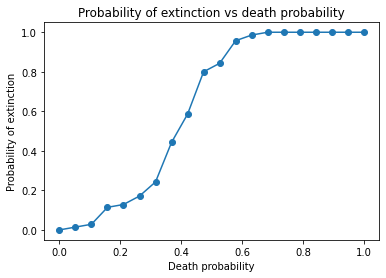

In [44]:
def extintion_different_pk(initial_pop, target, death_probs = np.linspace(0,1,20), max_gen = 12, N_SIM = 70):
    """Computes the estimation of extintion with different death probabilities"""
    estimated_probs = []
    p = IntProgress(min=0,max=len(death_probs))
    display.display(p)
    for i in range(len(death_probs)):
        death_prob = death_probs[i]
        birth_prob = (1. - death_prob) / 3
        k_prob = (death_prob, birth_prob, birth_prob, birth_prob)
        estimated_probs.append(branching_absortion(initial_pop, k_prob, target, max_gen, N_SIM)[0])
        p.value += 1
    
    p.bar_style = "success"
    display.clear_output()
    plt.plot(death_probs,estimated_probs)
    plt.scatter(death_probs,estimated_probs)
    plt.title("Probability of extinction vs death probability")
    plt.xlabel("Death probability")
    plt.ylabel("Probability of extinction")
    return estimated_probs

estimated_probs = extintion_different_pk(2,[0])